#### Libraries

In [66]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
# high-level plots
import seaborn as sns

import statsmodels.api as sm

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

import statsmodels.api as sm

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split, GridSearchCV
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# Support vector machine - support vector regressor
from sklearn.svm import SVR
# decision trees
from sklearn.tree import DecisionTreeRegressor, plot_tree
# mean squared error
from sklearn.metrics import mean_squared_error

# gradient boosting trees
from xgboost import XGBRegressor

# we use it to interact with the file system
import os
# compute time
from time import time

# Neural network high level framework
import keras
# Sequential is a sequence of blocs
# Input deals with the data fed to the network
from keras.models import Sequential,Input,Model
# Dense is a feedforward layer with fully connected nodes
# Dropout allows to keep part of data, and to "drop out" a the rest
# Flatten makes the data "flat", i.e. in one dimension
from keras.layers import Dense, Dropout, Flatten
# Conv -> convolution, MaxPooling is relative to Pooling
# Activation if the function composing the data in output of a layer
from keras.layers import Conv2D, MaxPooling2D, Activation


from learner.mlearner import learn_with_interactions, learn_without_interactions, sample_random, stepwise_feature_selection
from learner.model import genModelTermsfromString, Model, genModelfromCoeff

import warnings
warnings.filterwarnings("ignore")

#### Implementation of the approach

In [67]:
predDimension = "size"

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def time_to_sec(el):
    tab = el.split(":")
    return float(tab[0])*60+float(tab[1][:-1])

files = dict()
res =  dict()

file_names = sorted(os.listdir('../data/x264'))
inputs = [f.split("_")[2] for f in file_names]

for i in range(len(inputs)):
    files[inputs[i]] = file_names[i]

softs = ['x264', 'x265']

to_keep = ['aq-strength', 'ipratio', 'pbratio', 'qblur', 'psy-rd', 'qcomp', 'vbv-init', 'aq-mode', 'b-adapt',
           'bframes', 'crf', 'keyint', 'lookahead-threads', 'min-keyint', 'qp', 'qpstep', 'qpmin', 
           'qpmax', 'rc-lookahead', 'ref', 'vbv-bufsize', 'scenecut', 'aud', 'constrained-intra', 
           'intra-refresh', 'no-asm', 'slow-firstpass', 'weightb', 'deblock', 'me', 'overscan', 
           'preset', 'tune']

num = ['aq-strength', 'ipratio', 'pbratio', 'qblur', 'qcomp', 'psy-rd', 'qcomp', 'vbv-init', 'aq-mode', 
       'b-adapt', 'bframes', 'crf', 'keyint', 'lookahead-threads', 'min-keyint', 'qp', 'qpstep', 
       'qpmin', 'qpmax', 'rc-lookahead', 'ref', 'vbv-bufsize', 'scenecut']

categ = ['aud', 'constrained-intra', 'intra-refresh', 'no-asm', 'slow-firstpass', 'weightb', 
         'deblock', 'me', 'overscan', 'preset', 'tune']

for soft in softs:
    for inp in inputs:
        df = pd.read_csv("../data/"+soft+"/"+ files[inp])
        df['etime'] = [time_to_sec(k) for k in df["elapsedtime"]]
        for feat in ["elapsedtime"]:#"user", "system", 
            del df[feat]
        df_modif = df[num].join(pd.get_dummies(df[categ]))
        df_modif[predDimension] = df[predDimension]
        res[soft, inp] = df_modif

res["x264", "Animation"].head()

,aq-strength,ipratio,pbratio,qblur,qcomp,psy-rd,qcomp,vbv-init,aq-mode,b-adapt,...,preset_slower,preset_superfast,preset_ultrafast,preset_veryfast,preset_veryslow,tune_animation,tune_grain,tune_psnr,tune_ssim,size
0,0.0,1.0,1.0,0.3,0.6,1.8,0.6,0.6,1,1,...,0,0,0,0,1,0,0,0,1,337672
1,0.0,1.1,1.2,0.2,0.8,0.4,0.8,0.9,0,1,...,0,0,0,0,0,0,1,0,0,904268
2,3.0,1.5,1.4,0.2,0.8,2.8,0.8,0.2,2,1,...,0,0,1,0,0,0,0,0,1,183293
3,0.0,1.4,1.2,0.4,0.8,3.8,0.8,0.4,3,2,...,0,0,0,0,0,0,1,0,0,587744
4,1.0,1.2,1.4,0.6,0.6,0.8,0.6,0.9,1,1,...,0,0,0,0,0,1,0,0,0,8594537


### L2S

>@inproceedings{jamshidi2018,
    title={Learning to sample: exploiting similarities across environments to learn performance models for configurable systems}, 
    author={Jamshidi, Pooyan and Velez, Miguel and K{\"a}stner, Christian and Siegmund, Norbert},
    booktitle={Proceedings of the 2018 26th ACM Joint Meeting on European Software Engineering Conference and Symposium on the Foundations of Software Engineering},
    pages={71--82},
    year={2018},
    organization={ACM},
    url={https://dl.acm.org/doi/10.1145/3236024.3236074},
}

**Learning to Sample (L2S)** is a transfer learning approach defined by Jamshidi et al. 
First, it exploits the source software sytem and selects configurations that leverage influential (interactions of) features for this software sytem. 
Then, it explores the similarities between the source and the target, thus adding configurations having similar performances for the source and the target. 
Finally, it uses the configurations selected in previous steps to efficiently train a model on the target software sytem. 

In [68]:
class L2S():
    
    def __init__(self):
        pass
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true-y_pred)**2)
    
    def mean_absolute_percentage_error(self, y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    ### Step 1: Extraction Process of Performance Models
    
    #Select a good model for predicting the performance of the source video
    
    #Original files:
    #https://github.com/cmu-mars/model-learner/blob/tutorial/learner/mlearner.py for the stepwise selection
    #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html for the interactions
    
    # @PooyanJamshidi:
    # We just change slightly some functions from the original repository,
    # mainly because we don't want to add a constant in the model
    # + steps 2 and 3 were implemented in matlab but we did not find them in python
    def stepwise_selection(self, X, y,
                           initial_list = [], 
                           threshold_in = 0.00001, 
                           threshold_out = 0.05, 
                           verbose=False):

        ndim = X.shape[1]
        features = [i for i in range(ndim)]
        included = list(initial_list)

        while True:
            changed=False

            # forward step (removed a constant)
            excluded = list(set(features)-set(included))
            new_pval = pd.Series(index=excluded)
            for new_column in excluded:
                model = sm.OLS(y, pd.DataFrame(X[included+[new_column]])).fit()
                new_pval[new_column] = model.pvalues[new_column]
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed=True
                if verbose:
                    print('Add {:30} with p-value {:.5}'.format(best_feature, best_pval))

            # backward step
            model = sm.OLS(y, pd.DataFrame(X[included])).fit()
            pvalues = model.pvalues
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                changed = True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose:
                    print('Drop {:30} with p-value {:.5}'.format(worst_feature, worst_pval))
            if not changed:
                if verbose:
                    print("Construction of the model completed!")
                break
        return included
    
    ### Step 2: Active Sampling
    
    #### A - ] Exploitation : use the source's prediction model
    
    ##### (i) Sort the coefficients of the previous constructed model
    ##### (ii) Choose the coefficient with the highest value
    ##### (iii) Select the configurations with this feature activated

    # I assumed it was recursive, with a decreasing influence in the selection 
    # for a decreasing importance in the regression.
    
    def select_exploitation(self, df, sc, config_selected):
        
        self.nb_config = int(self.nb_config_exploitation - len(config_selected))
        
        if self.nb_config == 0:
            #print("Done!\n")
            return config_selected

        # if we don't have any important coefficient left to help us choose configs
        # we take the nb_config first configurations
        if len(sc) == 0:
            #print("Selecting " + str(self.nb_config) + " configurations from the rest of the dataset!")
            for conf in df.index[0:self.nb_config]:
                config_selected.append(conf)
            return config_selected

        # otherwise we just use the best coef to choose configs
        else:

            # we choose the best features coef (biggest absolute value)
            most_important_coef = sc[0]

            #print("Feature : " + str(most_important_coef))

            # configs with this feature activated
            imp_index = np.where(df[most_important_coef]==1)[0]

            # number of configs with this feature activated
            nb_imp_index = len(imp_index)

            # if we have more values to choose 
            # than the number of configurations with the best feature activated
            # we add all the configuration to the selected set
            # and we select the rest of the configuration based on other coefficients
            if nb_imp_index <= self.nb_config:
                for conf in df.iloc[imp_index].index:
                    config_selected.append(conf)
                #if nb_imp_index > 0:
                #    print("Added "+str(nb_imp_index)+ " values, "+
                #          str(self.nb_config-nb_imp_index)+" left to choose \n")
                # then we apply recursively this method to the rest of the dataframe
                return self.select_exploitation(df.iloc[np.where(df[most_important_coef]==0)[0]], 
                                              sc[1:len(sc)],
                                              config_selected)

            # otherwise we have enough values with this features activated
            # to select all the remaining configurations
            # so we apply the method to the dataframe containing all the feature activated
            # and we select the configuration by using the followings features
            else:
                return self.select_exploitation(df.iloc[imp_index], 
                                     sc[1:len(sc)], 
                                     config_selected)
    
    
    
    #### B-] Exploration : Select specific configurations, similar between the source and the target
    
    # I choose to select the group in one step:
    # if you select config per config, you may choose a local optimal
    
    def select_exploration(self, exploitation_conf, ratio_exploitation, number_group = 10):
        
        nb_exploration = np.round(self.config_tot*(1-ratio_exploitation), 1)

        #target = self.listVideo[id_target]

        # all the config left for exploration
        # total minus those chosen for exploitation
        explor_conf = np.setdiff1d(self.source.index, exploitation_conf)

        # initialization : we take the first nb_exploration config
        best_explor = explor_conf[0:nb_exploration]

        # we group it with the exploitation configurations
        conf = np.concatenate((exploitation_conf, best_explor), axis=0)
        
        # for the moment, it's our best entropy
        best_entropy = sc.entropy(self.target.iloc[conf][self.predDimension], 
                                  self.source.iloc[conf][self.predDimension])

        # then we incrementally select the configurations to diminish the entropy 
        group_counter = 0

        while group_counter < number_group:

            group_counter +=1

            # current group to 'challenge' the best result
            np.random.shuffle(explor_conf)
            current_explor = explor_conf[0:nb_exploration]

            # we group it with the exploitation configurations
            conf = np.concatenate((exploitation_conf, current_explor), axis=0)

            # we compute the Kullback Leibler divergence between the source and the target
            current_entropy = sc.entropy(self.target.iloc[conf][self.predDimension], 
                                         self.source.iloc[conf][self.predDimension])

            # we finally take the group giving the lowest entropy
            # if this group is better than the best group, we replace it by the new one
            if current_entropy > best_entropy:
                #print("Entropy gained : "+str(current_entropy-best_entropy))
                best_entropy = current_entropy
                best_explor = current_explor

        return best_explor
    
    
    def learn(self, 
              source, 
              target, 
              predDimension, 
              ratio_exploitation = 0.3,
              train_size = 20,
              learning_algorithm = RandomForestRegressor):
        
                
        # random state , i.e. a seed to split the source and the target datasets
        # by using the same set of configurations for training and testing
        random_state = np.random.randint(0,1000)

        # the predicted dimension, in our experiements the elapsed time
        self.predDimension = predDimension
        
        # the source video
        self.source = source

        # the number of config used in the training
        self.config_tot = int(train_size)
        
        if train_size <= 1:
            self.config_tot = int(train_size*self.source.shape[0])

        # transform some variables into dummies, to fit the orginal paper
        # since we don't want to introduce a meaningless constant in the model, 
        # we have to keep all columns

        X_src = pd.DataFrame(np.array(self.source.drop([self.predDimension], axis = 1), dtype=int))

        #X_src = self.source[self.keep_features]
        
        # add interactions
        poly = PolynomialFeatures(degree = 1, interaction_only = True, include_bias = True)
        
        # degree 2 take too much time + it will not scale for large configuration spaces...
        # IMO O(n) or O(nlog(n)) are the complexity we should all target for our algorithms
        
        X_interact = X_src
        # X_interact = pd.DataFrame(np.array(poly.fit_transform(X_src), int))

        # performance variable, to predict
        y_src = self.source[self.predDimension]
        
        # we train the model with the training data
        
        # print("\n############### I- Knowledge extraction #################\n")

        selected_features = self.stepwise_selection(X_interact, y_src)

        # print("\n############### II- Sampling #################\n")

        reg = LinearRegression()

        reg.fit(X_interact[selected_features], y_src)

        sorted_coefs = pd.Series(np.abs(reg.coef_), 
                                 selected_features, 
                                 dtype='float64').sort_values(ascending=False).index

        # print("A- EXPLOITATION\n")
        
        self.nb_config_exploitation = np.round(ratio_exploitation*self.config_tot, 1)
        
        exploitation_conf = self.select_exploitation(X_interact, sorted_coefs, [])
        
        # print(exploitation_conf)

        # print("\nB- EXPLORATION\n")

        # we ensure we sample the configurations of the training set
        # which removes the potential threat of using the configuration of the testing set
        # during the training
        
        # target
        self.target = target
        
        exploration_conf = self.select_exploration(exploitation_conf, ratio_exploitation)

        sampled_conf = np.concatenate((exploitation_conf,exploration_conf), axis=0)
        
        # print(sampled_conf)
        
        # print("\n############### III- Performance Model Learning #################\n")

        # we build a performance model for the target
        # instead of using all the configurations, we use the sampled configuration
        # ie we remove the unnecessary configurations
        # print(len(sampled_conf))
        
        X_tgt = self.target.drop([self.predDimension], axis = 1)
        y_tgt = self.target[self.predDimension]

        X_tgt_tr = X_tgt.iloc[sampled_conf]
        y_tgt_tr = y_tgt[sampled_conf]
        
        X_tgt_te = self.target.drop(sampled_conf, inplace = False, axis=0).drop([self.predDimension], axis = 1)
        y_tgt_te = self.target[self.predDimension].drop(sampled_conf, inplace = False, axis=0)

        # The shift function, to transfer the prediction from the source to the target
        lf = learning_algorithm()
        lf.fit(X_tgt_tr, y_tgt_tr)
        y_tgt_pred = lf.predict(X_tgt_te)
        
        # We return the mean average percentage error 
        # between the real values of y_test from target 
        # and the predictions shifted 
        return self.mean_absolute_percentage_error(y_tgt_te, y_tgt_pred)

In [69]:
class MS():
    
    def __init__(self):
        pass
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true-y_pred)**2)
        
    def mean_absolute_percentage_error(self, y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    def learn(self, source, target, predDimension, train_size, 
                    learning_algorithm = RandomForestRegressor, 
                    shift_function = RandomForestRegressor):
        
        # random state , i.e. a seed to split the source and the target datasets
        # by using the same set of configurations for training and testing
        random_state = np.random.randint(0,1000)
        
        # the variable of interest
        self.predDimension = predDimension
        
        # we take the source video, and split it into train-test
        X_src = source.drop([self.predDimension], axis = 1)
        y_src = np.array(source[self.predDimension], dtype=float)
        X_src_train, X_src_test, y_src_train, y_src_test = train_test_split(X_src, 
                                                                            y_src, 
                                                                            train_size=train_size,
                                                                            random_state = random_state)
        # we take the target video, split it into train-test
        X_tgt = target.drop([self.predDimension], axis = 1)
        y_tgt = np.array(target[self.predDimension], dtype=float)
        X_tgt_train, X_tgt_test, y_tgt_train, y_tgt_test = train_test_split(X_tgt, 
                                                                            y_tgt, 
                                                                            train_size=train_size,
                                                                            random_state = random_state)
        
        lf = learning_algorithm()
        lf.fit(X_src, y_src)
        y_src_pred_test = np.array(lf.predict(X_src_test)).reshape(-1,1)

        # The shift function, to transfer the prediction from the source to the target
        shift = shift_function()
        shift.fit(np.array(y_src_train).reshape(-1,1), y_tgt_train)
        y_tgt_pred_test = shift.predict(y_src_pred_test.reshape(-1,1))

        # We return the mean average percentage error 
        # between the real values of y_test from target 
        # and the predictions shifted 
        return self.mean_absolute_percentage_error(y_tgt_test, y_tgt_pred_test)

In [70]:
class NT():
    
    def __init__(self):
        pass
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true-y_pred)**2)
        
    def mean_absolute_percentage_error(self, y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    def learn(self, target, predDimension, train_size, 
                    learning_algorithm = RandomForestRegressor):

        X = target.drop([predDimension], axis = 1)
        y = target[predDimension]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)

        clf = RandomForestRegressor()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        return mean_absolute_percentage_error(y_test, y_pred)

In [25]:
video = "Gaming"

source = res["x264", video]
target = res["x265", video]

train_size = 100

for trs in [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 500, 1000, 2000]:
    
    print(trs)

    ms = MS()
    print("MS", 
          str(ms.learn(source, 
                       target, 
                       predDimension, 
                       trs)))

    nt = NT()
    print("NT", str(nt.learn(target, 
                             predDimension, 
                             trs)))

    l2s = L2S()
    #print("L2S", str(l2s.learn(source, target, predDimension, ratio_exploitation=1, train_size = trs)))

5
MS 138.96152301637045
NT 1417.6786950634962
10
MS 52.90411863790544
NT 853.3785394300328
20
MS 19.109772682556713
NT 246.2134063743443
30
MS 9.515206141098366
NT 112.69837373995975
40
MS 7.970769465718471
NT 39.071248164687425
50
MS 8.001480845652369
NT 9.842949455012679
60
MS 7.808161673956127
NT 9.607983270875764
70
MS 7.362484662348614
NT 8.462169975207246
80
MS 7.3199675068591805
NT 8.139638934541004
90
MS 7.487193473349343
NT 8.567984584503758
100
MS 7.5450583651752305
NT 7.930458718726179
500
MS 7.659994969170553
NT 6.14302710343643
1000
MS 7.409603323114553
NT 4.30819216562359
2000
MS 7.357179111159865
NT 3.692109550121608


In [ ]:
predDimension = "size"

pred = dict()

for video in inputs:
    
    print(video)
    
    source = res["x264", video]
    target = res["x265", video]
    
    #[0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
    
    prop_conf_target = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]
    conf_tot = 3125

    repetition = 5

    #for pct in prop_conf_target:
    for trs in prop_conf_target:
        
        print(trs)

        #train_size = int(pct*conf_tot)

        # Learning to Sample
        #l2s = L2S()
        #res_l2s = [l2s.learn(source, target, predDimension, ratio_exploitation = 0.7, 
        #                 train_size = train_size) for i in range(repetition)]
        #pred[video, "L2S", pct] = (np.mean(res_l2s), np.std(res_l2s))


        # Model Shift
        ms = MS()
        res_ms = [ms.learn(source, target, predDimension, train_size = trs) for i in range(repetition)]
        pred[video, "MS", trs] = (np.mean(res_ms), np.std(res_ms))


        # No Transfer
        nt = NT()
        res_nt = [nt.learn(target, predDimension, trs) for i in range(repetition)]

        pred[video, "NT", trs] = (np.mean(res_nt), np.std(res_nt))

Animation
5
10
20
30
40
50
60
70
80
90
100
200
500
CoverSong
5
10
20
30
40
50
60
70
80
90
100
200
500
Gaming
5
10
20
30
40
50
60
70
80
90
100
200
500
Lecture
5
10
20
30
40
50
60
70
80
90
100
200
500
LiveMusic
5
10
20
30
40
50
60
70
80
90
100
200
500
LyricVideo
5
10
20
30
40
50
60
70
80
90
100
200
500
MusicVideo
5
10
20
30
40
50
60
70
80
90
100


In [ ]:
pred

'etime'

pred = {('Animation', 'MS', 5): (289.8017235076212, 142.29578223664947),
 ('Animation', 'NT', 5): (1015.0680826649921, 673.2030293751782),
 ('Animation', 'MS', 10): (223.48963300030317, 57.80307484547151),
 ('Animation', 'NT', 10): (613.3037642240258, 488.06892387271654),
 ('Animation', 'MS', 20): (220.9153441373634, 77.75274396646545),
 ('Animation', 'NT', 20): (986.6708548373902, 579.8226366277017),
 ('Animation', 'MS', 30): (198.51139537743092, 30.051827517956855),
 ('Animation', 'NT', 30): (768.1697147207767, 349.2587097916787),
 ('Animation', 'MS', 40): (210.82309432335302, 66.62218472086384),
 ('Animation', 'NT', 40): (440.56538315346216, 199.120880644169),
 ('Animation', 'MS', 50): (221.49589278606763, 37.44529304313415),
 ('Animation', 'NT', 50): (372.3948464588464, 144.46361701466427),
 ('Animation', 'MS', 60): (202.76323536940103, 24.168724251207692),
 ('Animation', 'NT', 60): (269.93362399933875, 93.01466879739066),
 ('Animation', 'MS', 70): (207.6546255405956, 21.93997378051856),
 ('Animation', 'NT', 70): (204.40754585191613, 40.39648416770486),
 ('Animation', 'MS', 80): (259.57094524230297, 42.72894434526903),
 ('Animation', 'NT', 80): (152.18703292982326, 28.16208991356682),
 ('Animation', 'MS', 90): (247.37681338131688, 42.231633813319576),
 ('Animation', 'NT', 90): (116.86196533758849, 19.190916568282287),
 ('Animation', 'MS', 100): (242.59296821654243, 52.61119487421974),
 ('Animation', 'NT', 100): (134.97062175758188, 31.010532933265697),
 ('Animation', 'MS', 200): (239.88766880936336, 37.25538845899015),
 ('Animation', 'NT', 200): (66.58085304004548, 10.024397403366242),
 ('Animation', 'MS', 500): (226.7488827328958, 15.958886547513762),
 ('Animation', 'NT', 500): (34.87602481950281, 1.3330757249178289),
 ('CoverSong', 'MS', 5): (237.46629134429, 145.40368268056804),
 ('CoverSong', 'NT', 5): (905.541058585887, 738.9748358759122),
 ('CoverSong', 'MS', 10): (348.7227625387727, 177.92000158988415),
 ('CoverSong', 'NT', 10): (786.2262066581702, 439.6457838374577),
 ('CoverSong', 'MS', 20): (235.5328797945625, 112.26415758253648),
 ('CoverSong', 'NT', 20): (626.6488145217884, 192.77212664996307),
 ('CoverSong', 'MS', 30): (222.58741273433708, 70.0431166317808),
 ('CoverSong', 'NT', 30): (679.422779296445, 254.74973462385003),
 ('CoverSong', 'MS', 40): (341.78434506091764, 98.0243781378821),
 ('CoverSong', 'NT', 40): (459.0337109316232, 69.3177713565458),
 ('CoverSong', 'MS', 50): (271.21263079630836, 30.049565126347403),
 ('CoverSong', 'NT', 50): (311.0353874855415, 88.89897008733678),
 ('CoverSong', 'MS', 60): (245.96293070985365, 58.7096750655226),
 ('CoverSong', 'NT', 60): (223.16790953197975, 45.2213489579864),
 ('CoverSong', 'MS', 70): (261.4147389428914, 44.986029931362566),
 ('CoverSong', 'NT', 70): (176.70530045489946, 54.73212744748151),
 ('CoverSong', 'MS', 80): (226.75655304819725, 70.27576065881237),
 ('CoverSong', 'NT', 80): (131.8839207859368, 54.022542989686734),
 ('CoverSong', 'MS', 90): (259.86291539778415, 28.529551676441308),
 ('CoverSong', 'NT', 90): (127.64153011459875, 46.04380139055007),
 ('CoverSong', 'MS', 100): (267.93733580530426, 17.697051635672157),
 ('CoverSong', 'NT', 100): (89.46241304092777, 2.289038257176991),
 ('CoverSong', 'MS', 200): (227.49480722801837, 25.078460570546227),
 ('CoverSong', 'NT', 200): (60.99282617641703, 3.268396409922065),
 ('CoverSong', 'MS', 500): (219.9380798934566, 21.082702806213625),
 ('CoverSong', 'NT', 500): (33.01421537487623, 2.057270371283314),
 ('Gaming', 'MS', 5): (262.32572123827003, 129.16691416887),
 ('Gaming', 'NT', 5): (930.9469141221743, 975.0118915933133),
 ('Gaming', 'MS', 10): (152.26845443845005, 88.26838420668997),
 ('Gaming', 'NT', 10): (474.27909462515584, 182.1098164846366),
 ('Gaming', 'MS', 20): (189.22570095226695, 18.93782653328653),
 ('Gaming', 'NT', 20): (291.99644128878424, 185.14833549166957),
 ('Gaming', 'MS', 30): (152.7624265309485, 25.79069876461132),
 ('Gaming', 'NT', 30): (557.4932462156149, 85.97030425390942),
 ('Gaming', 'MS', 40): (176.35558179282484, 51.48048095868836),
 ('Gaming', 'NT', 40): (469.1446984262196, 275.2275721845314),
 ('Gaming', 'MS', 50): (153.73992551982695, 23.706471968758855),
 ('Gaming', 'NT', 50): (271.22218799547244, 82.38997141474114),
 ('Gaming', 'MS', 60): (154.9655068395312, 27.597013848725794),
 ('Gaming', 'NT', 60): (165.88568704821864, 65.46447029491917),
 ('Gaming', 'MS', 70): (150.51615271731075, 16.095600387030302),
 ('Gaming', 'NT', 70): (115.31788279578015, 42.40226999576463),
 ('Gaming', 'MS', 80): (160.6421860872253, 14.787061073107006),
 ('Gaming', 'NT', 80): (137.5631215390009, 50.20468633066774),
 ('Gaming', 'MS', 90): (154.28874767873126, 11.268153543457471),
 ('Gaming', 'NT', 90): (131.7656274142343, 66.29261317419514),
 ('Gaming', 'MS', 100): (150.5026627462782, 18.771525430966673),
 ('Gaming', 'NT', 100): (106.59084885947898, 60.796113314797076),
 ('Gaming', 'MS', 200): (161.9957129723548, 3.9007035722108747),
 ('Gaming', 'NT', 200): (66.37804018703409, 20.759079628021187),
 ('Gaming', 'MS', 500): (154.42898509303384, 8.08938723513083),
 ('Gaming', 'NT', 500): (31.367501088664643, 1.3433838559241924),
 ('Lecture', 'MS', 5): (304.9128334961948, 100.79243167373252),
 ('Lecture', 'NT', 5): (1024.9355139696504, 715.5224138115352),
 ('Lecture', 'MS', 10): (298.496083335746, 178.55468359098907),
 ('Lecture', 'NT', 10): (586.6631608668591, 323.6793207424358),
 ('Lecture', 'MS', 20): (240.93733551014458, 64.87782512412987),
 ('Lecture', 'NT', 20): (1013.1104453429234, 474.6334609150473),
 ('Lecture', 'MS', 30): (279.71217675139144, 42.06542950166274),
 ('Lecture', 'NT', 30): (656.4971061661661, 339.59267216996926),
 ('Lecture', 'MS', 40): (240.59295185487122, 38.38271404464237),
 ('Lecture', 'NT', 40): (418.6639154939233, 178.12594873268702),
 ('Lecture', 'MS', 50): (251.7304862138455, 47.65569088425329),
 ('Lecture', 'NT', 50): (261.4966250650119, 86.06211241979432),
 ('Lecture', 'MS', 60): (262.69381321343866, 77.55451518968981),
 ('Lecture', 'NT', 60): (318.3190204022773, 128.35818121456765),
 ('Lecture', 'MS', 70): (240.76861006869814, 42.22525929476972),
 ('Lecture', 'NT', 70): (158.708364899767, 41.87591519379094),
 ('Lecture', 'MS', 80): (247.73748573669863, 37.1509325876486),
 ('Lecture', 'NT', 80): (122.94371178187252, 21.332932806169698),
 ('Lecture', 'MS', 90): (274.32976565035926, 52.57245562617235),
 ('Lecture', 'NT', 90): (101.45638890375052, 11.935137920656171),
 ('Lecture', 'MS', 100): (230.926600012174, 32.77058734712071),
 ('Lecture', 'NT', 100): (111.89067601608812, 14.919215595930897),
 ('Lecture', 'MS', 200): (267.52422343594645, 26.552937387897952),
 ('Lecture', 'NT', 200): (65.02082128695606, 8.958941059218198),
 ('Lecture', 'MS', 500): (251.42039505352076, 6.952320578716531),
 ('Lecture', 'NT', 500): (32.856731211701685, 2.1772534230515013),
 ('LiveMusic', 'MS', 5): (266.400123116971, 199.669762083396),
 ('LiveMusic', 'NT', 5): (1175.3733612105407, 685.9525212744999),
 ('LiveMusic', 'MS', 10): (229.9539204571916, 141.295345177638),
 ('LiveMusic', 'NT', 10): (449.06498507889245, 195.2391206891681),
 ('LiveMusic', 'MS', 20): (198.57322459651138, 42.60043429490601),
 ('LiveMusic', 'NT', 20): (684.3740455805216, 248.61135264028778),
 ('LiveMusic', 'MS', 30): (206.95719170333933, 58.522484803340525),
 ('LiveMusic', 'NT', 30): (365.9519299054053, 228.23298472440715),
 ('LiveMusic', 'MS', 40): (203.08585486824722, 49.55296827674622),
 ('LiveMusic', 'NT', 40): (334.79458122046117, 131.1779557214087),
 ('LiveMusic', 'MS', 50): (189.56362340852948, 22.186581677624485),
 ('LiveMusic', 'NT', 50): (315.0187609229919, 83.44303554139508),
 ('LiveMusic', 'MS', 60): (182.15509720779175, 41.95743551759591),
 ('LiveMusic', 'NT', 60): (182.74287339506776, 83.06835031463287),
 ('LiveMusic', 'MS', 70): (193.0709202926409, 18.74992174185485),
 ('LiveMusic', 'NT', 70): (137.74857244121964, 24.548846002071066),
 ('LiveMusic', 'MS', 80): (214.01520144483965, 39.192405829664146),
 ('LiveMusic', 'NT', 80): (119.3565714653445, 28.63193243335226),
 ('LiveMusic', 'MS', 90): (194.0654896185485, 19.105702281006135),
 ('LiveMusic', 'NT', 90): (99.33382733017802, 13.818124212873679),
 ('LiveMusic', 'MS', 100): (206.94490612226053, 23.252658658867016),
 ('LiveMusic', 'NT', 100): (94.56369266283278, 18.93567079428309),
 ('LiveMusic', 'MS', 200): (186.46173056895609, 7.370466163073212),
 ('LiveMusic', 'NT', 200): (55.20084228926121, 3.914617614291109),
 ('LiveMusic', 'MS', 500): (191.073777295241, 10.713356106858376),
 ('LiveMusic', 'NT', 500): (31.178090049687835, 1.4433843905259043),
 ('LyricVideo', 'MS', 5): (88.83422943424843, 33.39027678599028),
 ('LyricVideo', 'NT', 5): (1259.3982195722797, 714.4177048288428),
 ('LyricVideo', 'MS', 10): (271.8250490682819, 122.54626651600793),
 ('LyricVideo', 'NT', 10): (616.6507154790495, 419.49668065020404),
 ('LyricVideo', 'MS', 20): (238.77824353046762, 18.094649400183528),
 ('LyricVideo', 'NT', 20): (724.7665185683924, 113.76608208586215),
 ('LyricVideo', 'MS', 30): (262.69473652595246, 79.97127339979583),
 ('LyricVideo', 'NT', 30): (608.9222805217128, 252.39959572328016),
 ('LyricVideo', 'MS', 40): (234.31140102119215, 54.19857780482973),
 ('LyricVideo', 'NT', 40): (350.3200739807463, 137.84311925644482),
 ('LyricVideo', 'MS', 50): (245.3861130327744, 26.823463802315313),
 ('LyricVideo', 'NT', 50): (358.5278978006324, 139.09436780400463),
 ('LyricVideo', 'MS', 60): (279.740456705936, 20.861412077627374),
 ('LyricVideo', 'NT', 60): (144.37044139247942, 45.429261454604934),
 ('LyricVideo', 'MS', 70): (243.36863013386855, 29.2050257787518),
 ('LyricVideo', 'NT', 70): (110.08181222220928, 21.90995797552997),
 ('LyricVideo', 'MS', 80): (252.79037467408875, 55.47332289620389),
 ('LyricVideo', 'NT', 80): (92.20331524180015, 15.19617958741938),
 ('LyricVideo', 'MS', 90): (223.79196938428768, 41.57866216522894),
 ('LyricVideo', 'NT', 90): (103.01719497719417, 33.912003295449956),
 ('LyricVideo', 'MS', 100): (220.05124991696613, 48.00930983339986),
 ('LyricVideo', 'NT', 100): (73.02615802010057, 18.722745061337662),
 ('LyricVideo', 'MS', 200): (261.7367260434053, 32.72983530822312),
 ('LyricVideo', 'NT', 200): (45.24147881703826, 5.561366038227965),
 ('LyricVideo', 'MS', 500): (252.7588218474541, 11.15990706818664),
 ('LyricVideo', 'NT', 500): (27.461897650921703, 1.455954490214024),
 ('MusicVideo', 'MS', 5): (383.524517980135, 318.9551589492831),
 ('MusicVideo', 'NT', 5): (1167.0448285336138, 880.3913812903515),
 ('MusicVideo', 'MS', 10): (250.2582514569704, 196.17809977938924),
 ('MusicVideo', 'NT', 10): (964.7738830014971, 460.2660290900116),
 ('MusicVideo', 'MS', 20): (249.2647120848334, 86.57961426569295),
 ('MusicVideo', 'NT', 20): (747.634708494604, 484.53988668035515),
 ('MusicVideo', 'MS', 30): (258.80714989960353, 68.41707664720084),
 ('MusicVideo', 'NT', 30): (643.9645576973251, 207.9967115037967),
 ('MusicVideo', 'MS', 40): (234.9044419260459, 37.15324706252514),
 ('MusicVideo', 'NT', 40): (380.28407179292685, 48.186840260501796),
 ('MusicVideo', 'MS', 50): (209.0254123973528, 53.587288715428286),
 ('MusicVideo', 'NT', 50): (232.70308034542714, 41.84130657195001),
 ('MusicVideo', 'MS', 60): (252.15555678039445, 58.09098892854786),
 ('MusicVideo', 'NT', 60): (176.3201571620751, 28.53992097210178),
 ('MusicVideo', 'MS', 70): (206.21469460882585, 45.21481431238928),
 ('MusicVideo', 'NT', 70): (160.48879096353582, 77.01833778643653),
 ('MusicVideo', 'MS', 80): (235.27515101800333, 22.042724932393913),
 ('MusicVideo', 'NT', 80): (129.90932280815903, 45.044268635057534),
 ('MusicVideo', 'MS', 90): (230.88396670994385, 44.639202663949746),
 ('MusicVideo', 'NT', 90): (98.84638147166004, 19.539365579415435),
 ('MusicVideo', 'MS', 100): (227.25309833894676, 33.801277902883484),
 ('MusicVideo', 'NT', 100): (88.02820112200752, 14.006033993004076),
 ('MusicVideo', 'MS', 200): (258.78575330527946, 31.947639826034084),
 ('MusicVideo', 'NT', 200): (51.09924609355447, 6.18458130937986),
 ('MusicVideo', 'MS', 500): (232.88153465790674, 12.697623199179125),
 ('MusicVideo', 'NT', 500): (27.37035362480063, 1.0823990340900047),
 ('Sports', 'MS', 5): (314.5125416001134, 221.32317690104887),
 ('Sports', 'NT', 5): (613.6596118883883, 277.55080415816377),
 ('Sports', 'MS', 10): (336.09783695295204, 293.8304524094049),
 ('Sports', 'NT', 10): (823.7698939510458, 397.49823543755934),
 ('Sports', 'MS', 20): (190.03226725367432, 57.9825414214613),
 ('Sports', 'NT', 20): (820.0907490952217, 260.56741419123904),
 ('Sports', 'MS', 30): (218.42758979011128, 71.47985170740347),
 ('Sports', 'NT', 30): (593.9263861204762, 113.85306361306193),
 ('Sports', 'MS', 40): (218.38590124991015, 35.75597833908706),
 ('Sports', 'NT', 40): (359.8194362473397, 134.1385042914579),
 ('Sports', 'MS', 50): (192.59020891438544, 32.742715389928286),
 ('Sports', 'NT', 50): (228.691654654577, 94.70653680188282),
 ('Sports', 'MS', 60): (183.98551186162445, 43.39790467455463),
 ('Sports', 'NT', 60): (233.07437374531042, 67.01205034307122),
 ('Sports', 'MS', 70): (199.87769826340542, 46.84834243403778),
 ('Sports', 'NT', 70): (158.010461126017, 44.05128811702644),
 ('Sports', 'MS', 80): (174.77972742507535, 36.86644560168709),
 ('Sports', 'NT', 80): (153.18684834151205, 18.595028053737725),
 ('Sports', 'MS', 90): (198.74347311307542, 26.24665939074219),
 ('Sports', 'NT', 90): (165.4341133072912, 68.94019548983873),
 ('Sports', 'MS', 100): (198.581590203803, 18.12707580205542),
 ('Sports', 'NT', 100): (123.6266172194078, 25.173092665748555),
 ('Sports', 'MS', 200): (204.1224815690999, 9.3629604031742),
 ('Sports', 'NT', 200): (62.71279029852495, 10.486799205638865),
 ('Sports', 'MS', 500): (181.6712270023425, 8.199072934750948),
 ('Sports', 'NT', 500): (35.936634258794406, 1.287550483439431)}

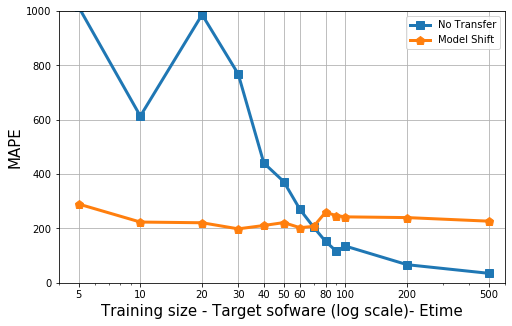

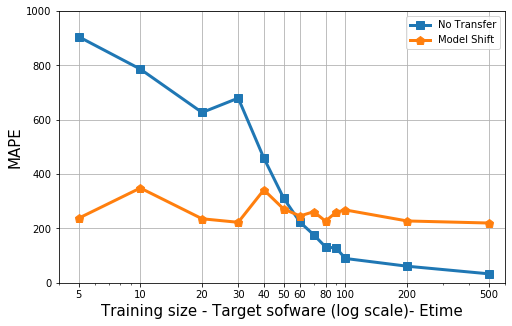

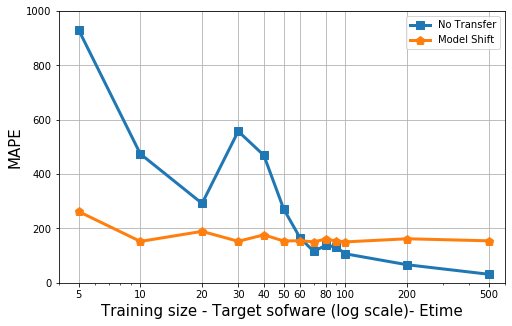

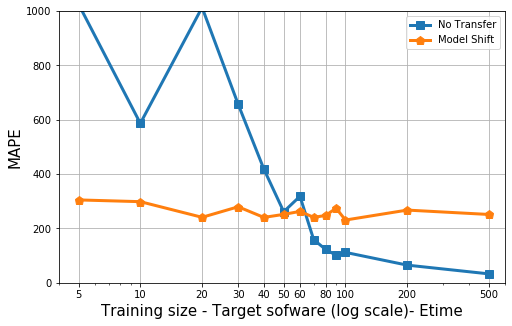

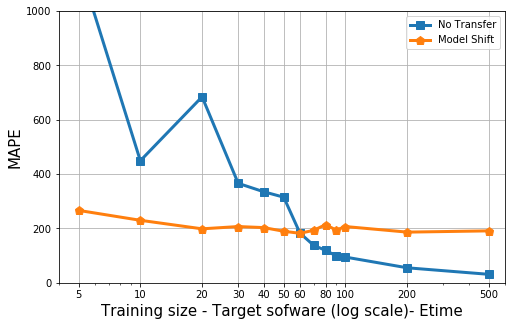

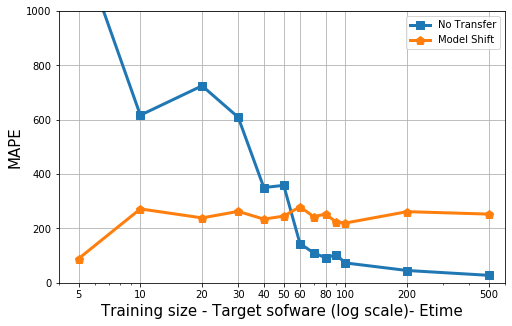

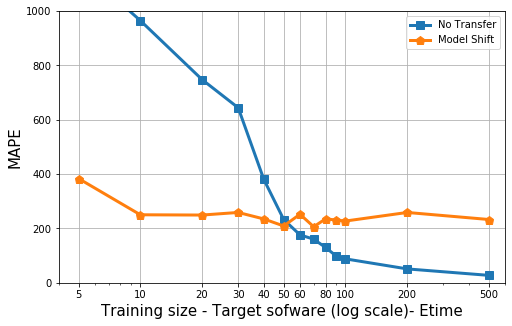

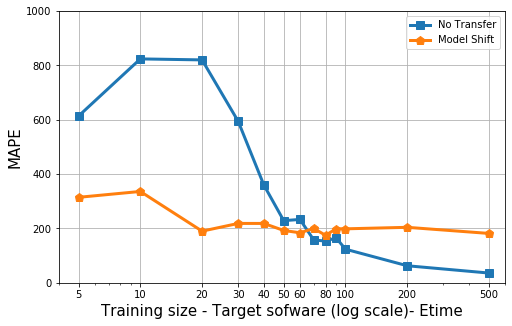

In [65]:
for inp in inputs:
    fig, ax = plt.subplots(figsize=((8, 5)))
    ax.plot(prop_conf_target, 
            [pred[inp, 'NT', p][0] for p in prop_conf_target], 
            marker='s', 
            markersize = 8,
            linewidth = 3,
            label = 'No Transfer')
    ax.plot(prop_conf_target, 
             [pred[inp, 'MS', p][0] for p in prop_conf_target], 
              marker='p', 
              markersize = 9,
              linewidth = 3,
             label = 'Model Shift')
    plt.grid()
    plt.legend()
    plt.ylabel("MAPE", size = 15)
    plt.xlabel("Training size - Target sofware (log scale)- "+predDimension[0].upper()+predDimension[1:],
              size = 15)
    plt.ylim((0, 1000))
    plt.xlim((4, 600))
    ax.set_xscale('log')
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.set_xticks([5, 10, 20, 30, 40, 50, 60, 80, 100, 200, 500], minor= False)
    #plt.title(inp)
    plt.savefig("../results/pred_"+predDimension+'_'+inp+".png")
    plt.show()